In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.ensemble import GradientBoostingRegressor
from mapie.metrics import regression_coverage_score, regression_mean_width_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.linear_model import QuantileRegressor
from mapie.quantile_regression import MapieQuantileRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from lightgbm import LGBMRegressor

np.random.seed(1)
rng = np.random.default_rng(1)
random_state = 42

quantile_estimator_params = {
        "GradientBoostingRegressor": {
            "loss_name": "loss",
            "alpha_name": "alpha"
        },
        "QuantileRegressor": {
            "loss_name": "quantile",
            "alpha_name": "quantile"
        },
        "HistGradientBoostingRegressor": {
            "loss_name": "loss",
            "alpha_name": "alpha"
        },
        "LGBMRegressor": {
            "loss_name": "objective",
            "alpha_name": "alpha"
        },
}


# Function needed to run the notebooks

In [2]:
def get_data(funct, n_samples, noise=0.5, mu=None, sigma=None, min_x=0, max_x=10, data_name=None):
    """
    Returns simulated data.
    """
    if mu is not None and sigma is not None:
        X_train = np.random.normal(mu, sigma, n_samples)
        X_test = np.arange(mu-4*sigma, mu+4*sigma, sigma/20.)
    else:
        X_train = np.random.uniform(min_x, max_x, size=n_samples).astype(np.float32)
        X_test = np.random.uniform(min_x, max_x, size=n_samples).astype(np.float32)

    y_train, y_test, y_mesh = funct(X_train), funct(X_test), funct(X_test)

    if data_name!="paper_reproduction":
        y_train += rng.normal(0, noise, y_train.shape[0])
        y_test += rng.normal(0, noise, y_test.shape[0])

    if mu is None and sigma is None:
        X_train = np.reshape(X_train, (n_samples, 1))
        X_test = np.reshape(X_test, (n_samples, 1))
    X_train_, X_calib_, y_train_, y_calib_ = train_test_split(
        X_train,
        y_train,
        test_size=0.3,
        random_state=random_state
    )
    return X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, y_mesh


def get_estimator(name, poly_d=10):
    """
    Function to return an estimator.
    """
    if name == "GradientBoostingRegressor":
        return GradientBoostingRegressor(loss="quantile", random_state=random_state)
    if name == "QuantileRegressor":
        return QuantileRegressor(solver="highs", alpha=0)
    if name == "LGBMRegressor":
        return LGBMRegressor(objective='quantile', alpha=0.5)
    if name == "polynomial":
        degree_polyn = poly_d
        polyn_model_quant = Pipeline(
            [
                ("poly", PolynomialFeatures(degree=degree_polyn)),
                ("linear", QuantileRegressor(
                        solver="highs",
                        alpha=0,
                ))
            ]
        )
        return polyn_model_quant

def quantile_regression(checked_estimator, X_train, y_train, X_test, y_test, alpha):
    """
    Returns the output of quantile regression.
    """
    if isinstance(checked_estimator, Pipeline):
        estimator = checked_estimator[-1]
    else:
        estimator = checked_estimator
    name_estimator = estimator.__class__.__name__
    alpha_name = quantile_estimator_params[name_estimator]["alpha_name"]
    alphas = [alpha/2, (1 - alpha/2)]
    y_preds = []
    if isinstance(checked_estimator, Pipeline):
        for a in alphas:
            estimator_ = clone(checked_estimator)
            params = {alpha_name: a}
            estimator_[-1].set_params(**params)
            estimator_.fit(X_train, y_train)
            y_preds.append(estimator_.predict(X_test))
    else:
        for a in alphas:
            estimator_ = clone(estimator)
            params = {alpha_name: a}
            estimator_.set_params(**params)
            estimator_.fit(X_train, y_train)
            y_preds.append(estimator_.predict(X_test))
    return y_preds


def CQR_QR(X_train_, y_train_, X_calib_, y_calib_, X_test, y_test, alpha=0.1, symmetry=True, show_quantile=False):
    """

    """
    #MapieQuantileRegressor
    mapie_reg = MapieQuantileRegressor(
        estimator=estimator,
        alpha=alpha,
    )
    mapie_reg.fit(X_train_, y_train_, X_calib_, y_calib_)
    y_pred_cqr, y_pis_cqr = mapie_reg.predict(X_test, symmetry=symmetry)
    if show_quantile:
        if symmetry:
            print("Quantile added value: ", round(np.quantile(mapie_reg.conformity_scores_[2], 1-alpha), 3))
        else:
            print("Quantile lower bound added value: ", round(np.quantile(mapie_reg.conformity_scores_[0], 1-alpha/2), 3))
            print("Quantile upper bound added value: ", round(np.quantile(mapie_reg.conformity_scores_[1], 1-alpha/2), 3))

    #Normal Quantile Regression
    y_pred_qr = quantile_regression(estimator, X_train_, y_train_, X_test, y_test, alpha)
    return y_pred_qr, y_pred_cqr, y_pis_cqr


def plot_results(axs, X_test, y_test, y_pred_low_cqr, y_pred_high_cqr, y_pred_low=None, y_pred_high=None, y_lim=None):
    """
    Creates a plot of the results to compare quantile regression with CQR.
    """
    inds = np.argsort(np.squeeze(X_test))

    if y_pred_low is not None and y_pred_high is not None:
        axs.plot(X_test[inds], y_pred_low[inds], color="red")
        axs.plot(X_test[inds], y_pred_high[inds], color="red")

    axs.plot(X_test[inds], y_pred_low_cqr[inds], color="green")
    axs.plot(X_test[inds], y_pred_high_cqr[inds], color="green")
    axs.scatter(X_test[inds], y_test[inds], s=1, alpha=0.7)
    if y_lim == None:
        axs.set_ylim([np.min(y_test) * 1.3, np.max(y_test) * 1.3])
    else:
        axs.set_ylim([y_lim[0], y_lim[1]])
    plt.show()


# Simulated data

This is the replica of the paper by Romano et al. (2020), we can observe how coverage by CQR is significantly better than that of the QR.

/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:467: UserWarning: WARNING: The initial prediction values from the quantile method
present issues as the upper quantile values might be higher than the
lower quantile values.
  warnings.warn(
/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:479: UserWarning: WARNING: Following the additional value added to have conformal predictions, the upper and lower bound present issues as one might be higher or lower than the other.
  warnings.warn(


Quantile added value:  0.007
Initial coverage: 0.897
Coverage by Mapie:  0.932


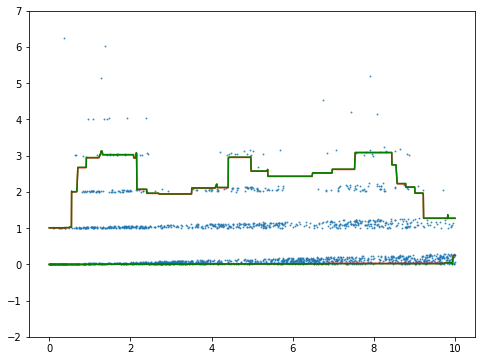

In [3]:
n_samples = 2000
def funct(x):
    ax = 0*x
    for i in range(len(x)):
        ax[i] = rng.poisson(np.sin(x[i])**2+0.1) + 0.03*x[i]*rng.random()
        ax[i] += 25*(rng.uniform(0, 1, 1) < 0.01)*rng.random()
    return ax.astype(np.float32)

X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(funct, n_samples, data_name="paper_reproduction")
estimator=get_estimator("GradientBoostingRegressor")

y_pred_qr, y_pred_cqr, y_pis_cqr = CQR_QR(X_train_, y_train_, X_calib_, y_calib_, X_test, y_test, show_quantile=True)

print("Initial coverage:", regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
print("Coverage by Mapie: ", regression_coverage_score(y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0]))

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_results(axs, X_test, y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0], y_pred_low=y_pred_qr[0], y_pred_high=y_pred_qr[1], y_lim=[-2, 7])


Simulated data from a linear function with a constant term

/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:467: UserWarning: WARNING: The initial prediction values from the quantile method
present issues as the upper quantile values might be higher than the
lower quantile values.
  warnings.warn(
/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:479: UserWarning: WARNING: Following the additional value added to have conformal predictions, the upper and lower bound present issues as one might be higher or lower than the other.
  warnings.warn(


Initial coverage: 0.895125
Coverage by Mapie:  0.902625


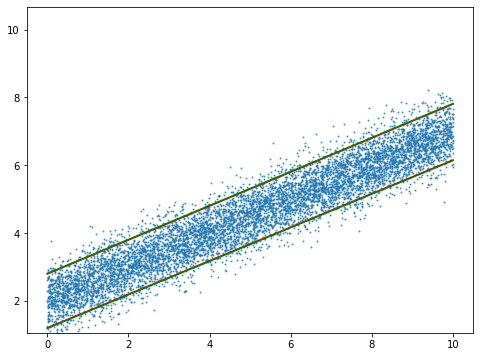

In [4]:
n_samples = 8000
def funct(x):
    a, b = 0.5, 2
    return a * x + b

X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(funct, n_samples)

estimator=get_estimator("QuantileRegressor")

y_pred_qr, y_pred_cqr, y_pis_cqr = CQR_QR(X_train_, y_train_, X_calib_, y_calib_, X_test, y_test)

print("Initial coverage:", regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
print("Coverage by Mapie: ", regression_coverage_score(y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0]))

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_results(axs, X_test, y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0], y_pred_low=y_pred_qr[0], y_pred_high=y_pred_qr[1])



Simulated data from a `x*sin(x)` function

Quantile added value:  0.002
Initial coverage: 0.875
Coverage by Mapie:  0.9


/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/sklearn/linear_model/_quantile.py:270: ConvergenceWarning: Linear programming for QuantileRegressor did not succeed.
Status is 4: Numerical difficulties encountered.
Result message of linprog:
An optimal solution to the scaled model was found but was HiGHS Status Code 0: HighsModelStatusNOTSET in the unscaled model. For more information run with the option `disp: True`.
  warnings.warn(
/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:467: UserWarning: WARNING: The initial prediction values from the quantile method
present issues as the upper quantile values might be higher than the
lower quantile values.
  warnings.warn(
/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:479: UserWarning: WARNING: Following the additional value added to have conformal predictions, the upper and lower bound present issues as one might be higher or

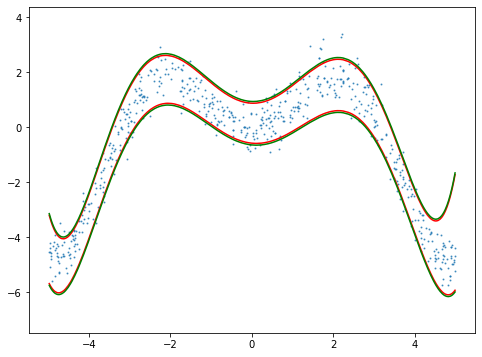

In [5]:
def x_sinx(x):
    """One-dimensional x*sin(x) function."""
    return x*np.sin(x)

X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, _ = get_data(x_sinx, n_samples=600, min_x=-5, max_x=5)

estimator=get_estimator("polynomial", poly_d=7)

y_pred_qr, y_pred_cqr, y_pis_cqr = CQR_QR(X_train_, y_train_, X_calib_, y_calib_, X_test, y_test, show_quantile=True)

print("Initial coverage:", regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
print("Coverage by Mapie: ", regression_coverage_score(y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0]))

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_results(axs, X_test, y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0], y_pred_low=y_pred_qr[0], y_pred_high=y_pred_qr[1])


/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:467: UserWarning: WARNING: The initial prediction values from the quantile method
present issues as the upper quantile values might be higher than the
lower quantile values.
  warnings.warn(
/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:479: UserWarning: WARNING: Following the additional value added to have conformal predictions, the upper and lower bound present issues as one might be higher or lower than the other.
  warnings.warn(


Initial coverage: 0.80625
Coverage by Mapie:  0.80625


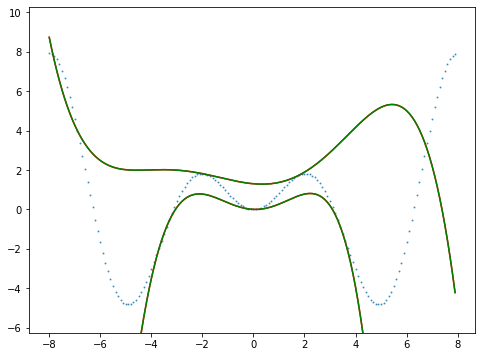

In [6]:
X_train_, X_calib_, y_train_, y_calib_, X_test, y_test, y_mesh = get_data(x_sinx, n_samples=6000, mu=0, sigma=2, noise=0)

estimator=get_estimator("polynomial", poly_d=5)

y_pred_qr, y_pred_cqr, y_pis_cqr = CQR_QR(X_train_.reshape(-1, 1), y_train_, X_calib_.reshape(-1, 1), y_calib_, X_test.reshape(-1, 1), y_test)

print("Initial coverage:", regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
print("Coverage by Mapie: ", regression_coverage_score(y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0]))

fig, axs = plt.subplots(1, 1, figsize=(8, 6))
plot_results(axs, X_test, y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0], y_pred_low=y_pred_qr[0], y_pred_high=y_pred_qr[1])


# Real datasets

In [7]:
data_url = "http://lib.stat.cmu.edu/datasets/boston"
raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
X_boston = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
y_boston = raw_df.values[1::2, 2]

# Split the data into training and test sets.
X_train, X_test, y_train, y_test = train_test_split(
    X_boston, y_boston, test_size=0.2, random_state=42
)

X_train_, X_calib_, y_train_, y_calib_ = train_test_split(
    X_train,
    y_train,
    test_size=0.3,
    random_state=random_state
)

estimator=get_estimator("GradientBoostingRegressor")

y_pred_qr, y_pred_cqr, y_pis_cqr = CQR_QR(X_train_, y_train_, X_calib_, y_calib_, X_test, y_test)

print("Initial coverage:", regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
print("Coverage by Mapie: ", regression_coverage_score(y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0]))

# fig, axs = plt.subplots(1, 1, figsize=(8, 6))
# plot_results(axs, X_test, y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0], y_pred_low=y_pred_qr[0], y_pred_high=y_pred_qr[1])


Initial coverage: 0.8431372549019608
Coverage by Mapie:  0.9705882352941176


/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:467: UserWarning: WARNING: The initial prediction values from the quantile method
present issues as the upper quantile values might be higher than the
lower quantile values.
  warnings.warn(
/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:479: UserWarning: WARNING: Following the additional value added to have conformal predictions, the upper and lower bound present issues as one might be higher or lower than the other.
  warnings.warn(


/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:467: UserWarning: WARNING: The initial prediction values from the quantile method
present issues as the upper quantile values might be higher than the
lower quantile values.
  warnings.warn(
/Users/llacombe/opt/miniconda3/envs/mapie_test/lib/python3.10/site-packages/mapie/utils.py:479: UserWarning: WARNING: Following the additional value added to have conformal predictions, the upper and lower bound present issues as one might be higher or lower than the other.
  warnings.warn(


Initial coverage: 0.8154761904761905
Coverage by Mapie:  0.8928571428571429


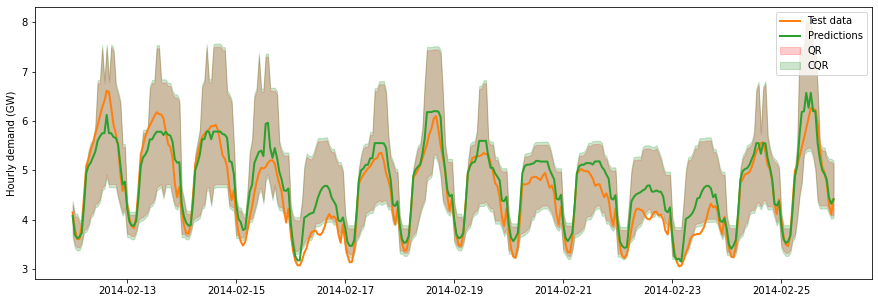

In [8]:
# Load input data and feature engineering
demand_df = pd.read_csv(
    "../data/demand_temperature.csv", parse_dates=True, index_col=0
)
demand_df["Date"] = pd.to_datetime(demand_df.index)
demand_df["Weekofyear"] = demand_df.Date.dt.isocalendar().week.astype("int64")
demand_df["Weekday"] = demand_df.Date.dt.isocalendar().day.astype("int64")
demand_df["Hour"] = demand_df.index.hour

# Train/validation/test split
num_test_steps = 24 * 7 * 2
demand_train = demand_df.iloc[:-num_test_steps, :].copy()
demand_test = demand_df.iloc[-num_test_steps:, :].copy()
X_train = demand_train.loc[:, ["Weekofyear", "Weekday",
                               "Hour", "Temperature"]].reset_index(drop=True).to_numpy()
y_train = demand_train["Demand"]
X_test = demand_test.loc[:, ["Weekofyear", "Weekday",
                             "Hour", "Temperature"]].reset_index(drop=True).to_numpy()
y_test = demand_test["Demand"]

X_train_, X_calib_, y_train_, y_calib_ = train_test_split(
    X_train,
    y_train,
    test_size=0.5,
    random_state=random_state
)

estimator = get_estimator("GradientBoostingRegressor")

y_pred_qr, y_pred_cqr, y_pis_cqr = CQR_QR(X_train_, y_train_, X_calib_, y_calib_, X_test, y_test)

print("Initial coverage:", regression_coverage_score(y_test, y_pred_qr[0], y_pred_qr[1]))
print("Coverage by Mapie: ", regression_coverage_score(y_test, y_pis_cqr[:, 0, 0], y_pis_cqr[:, 1, 0]))


# Plot estimated prediction intervals on test set
fig = plt.figure(figsize=(15, 5))
ax = fig.add_subplot(1, 1, 1)
ax.set_ylabel("Hourly demand (GW)")
ax.plot(y_test, lw=2, label="Test data", c="C1")
ax.plot(demand_test.index, y_pred_cqr, lw=2, c="C2", label="Predictions")
ax.fill_between(
    demand_test.index,
    y_pred_qr[0],
    y_pred_qr[1],
    color="red",
    alpha=0.2,
    label="QR",
)
ax.fill_between(
    demand_test.index,
    y_pis_cqr[:, 0, 0],
    y_pis_cqr[:, 1, 0],
    color="green",
    alpha=0.2,
    label="CQR",
)

ax.legend()
plt.show()
